# Experiment: Varying N in top-N DDA fragmentation

We demonstrate that the simulator can be used for scan-level closed-loop DDA experiments. 
- Take an existing data. Find out which MS1 peaks are linked to which MS2 peaks.
- Run all MS1 peaks through the simulator’s Top-N protocol. 
- For the top-100 most intense MS1 peaks, how many got fragmented in the simulator as we change N?
- If N is greater than the real data, do we see the same MS1 peaks from (1) being fragmented again, plus additional fragment peaks?
- Verification on actual machine.
- Talk to stefan about machine time.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import os
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt
from random import random, shuffle
from joblib import Parallel, delayed
import multiprocessing

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

In [6]:
set_log_level_debug()

### Load densities trained on beer1pos data (see [loader_kde](loader_kde.ipynb)).

In [7]:
base_dir = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\'

In [8]:
ps = load_obj(base_dir + 'Trained Models\\peak_sampler_beer1pos.p')

### Load chromatogram data exported from the real data (BEER1POS)

Correct the positively charged ions by substracting the mass of a proton

In [9]:
def f(peak_mz, chrom_mzs):
    peak_mz = peak_mz - PROTON_MASS
    chrom_mzs = chrom_mzs - PROTON_MASS
    return peak_mz, chrom_mzs

In [10]:
xcms_output = base_dir + 'Trained Models\\chromatogram_beer1pos.csv.gz'
cc = ChromatogramCreator(xcms_output, correction_func=f)

DEBUG:ChromatogramCreator:Loading 0 chromatograms
DEBUG:ChromatogramCreator:Invalid chromatogram 238
DEBUG:ChromatogramCreator:Invalid chromatogram 254
DEBUG:ChromatogramCreator:Invalid chromatogram 457
DEBUG:ChromatogramCreator:Invalid chromatogram 516
DEBUG:ChromatogramCreator:Invalid chromatogram 2132
DEBUG:ChromatogramCreator:Invalid chromatogram 2754
DEBUG:ChromatogramCreator:Invalid chromatogram 2797
DEBUG:ChromatogramCreator:Invalid chromatogram 3143
DEBUG:ChromatogramCreator:Invalid chromatogram 3459
DEBUG:ChromatogramCreator:Invalid chromatogram 3984
DEBUG:ChromatogramCreator:Invalid chromatogram 4081
DEBUG:ChromatogramCreator:Invalid chromatogram 4167
DEBUG:ChromatogramCreator:Invalid chromatogram 4218
DEBUG:ChromatogramCreator:Invalid chromatogram 4433
DEBUG:ChromatogramCreator:Invalid chromatogram 4575
DEBUG:ChromatogramCreator:Loading 5000 chromatograms
DEBUG:ChromatogramCreator:Invalid chromatogram 5150
DEBUG:ChromatogramCreator:Invalid chromatogram 5512
DEBUG:Chromatogra

#### Turn the loaded data into `UnknownChemical` objects.

In [11]:
min_ms1_intensity = 0
min_rt = 3*60
max_rt = 21*60
chemicals = ChemicalCreator(ps)
dataset = chemicals.sample_from_chromatograms(cc, min_rt, max_rt, min_ms1_intensity, ms_levels=2)

DEBUG:ChemicalCreator:10272 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 2500
DEBUG:ChemicalCreator:i = 5000
DEBUG:ChemicalCreator:i = 7500
DEBUG:ChemicalCreator:i = 10000


In [12]:
len(dataset)

9778

### Add noise

#### Create region of interest objects

In [13]:
mzml_path = base_dir + 'Data\\multibeers_urine_data\\beers\\fullscan\\'
xcms_roi_file = mzml_path + 'rois.csv'
extracted_roi_file = base_dir + 'Trained Models\\beer1pos_rois.p'

In [14]:
filename = 'Beer_multibeers_1_fullscan1.mzML'
ds = DataSource()
ds.load_data(mzml_path)
try:
    ds.load_roi(extracted_roi_file)
except FileNotFoundError:
    print('Extracting ROIs')
    ds.extract_roi(xcms_roi_file, min_rt=min_rt, max_rt=max_rt, filename=filename)
    ds.populate_roi(filename=filename)
    ds.save_roi(extracted_roi_file)

C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_10_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_10_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_11_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_11_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_12_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_12_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_13_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_13_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_14_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_14_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_15_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_15_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_16_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_16_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_17_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_17_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_18_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_18_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_19_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_19_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_1_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_1_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_2_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_2_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_3_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_3_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_4_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_4_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_5_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_5_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_6_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_6_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_7_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_7_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_8_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_8_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_9_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_9_fullscan1.mzML


#### Add a whole bunch of `UnknownChemicals` with chromatograms coming from non-peak ROIs from Beer1Pos

In [15]:
min_ms1_intensity = 2.5E5

In [16]:
rtcc = RoiToChemicalCreator(ps, ds, filename,  min_ms1_intensity=min_ms1_intensity)

DEBUG:RoiToChemicalCreator:     0/ 17569
../codes\VMSfunctions\Common.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  area += ((intensities[rt_index] + intensities[rt_index + 1]) / 2) / (rts[rt_index + 1] - rts[rt_index])
INFO:RoiToChemicalCreator:Found 1305 ROIs above thresholds


In [17]:
len(rtcc.chemicals)

1305

In [18]:
def plot_chems(chem_list, N=10):
    for c in chem_list[0:N]:
        chrom = c.chromatogram
        plt.plot(chrom.raw_rts, chrom.raw_intensities)
        plt.show()

In [19]:
sorted_chems = sorted(rtcc.chemicals, key = lambda chem: chem.chromatogram.roi.num_scans())

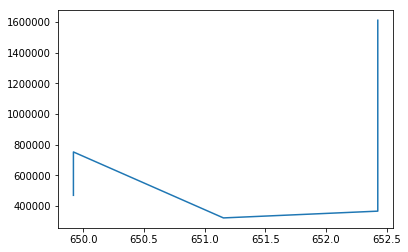

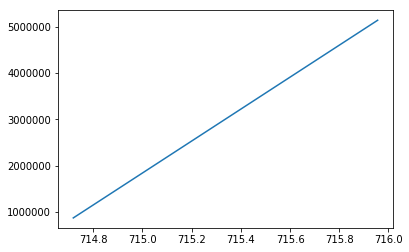

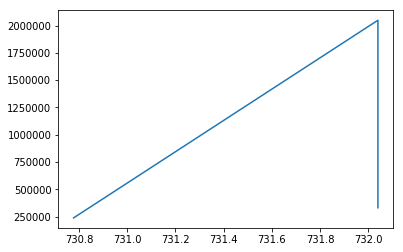

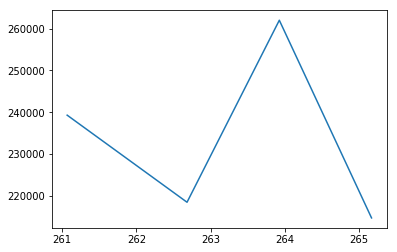

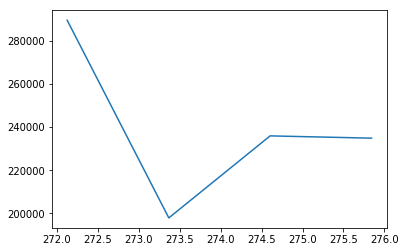

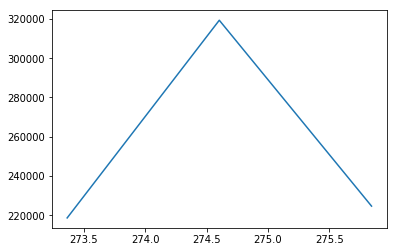

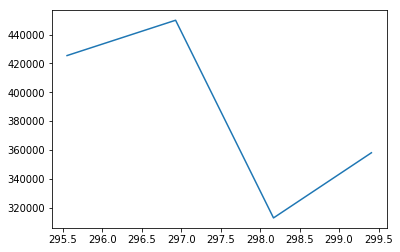

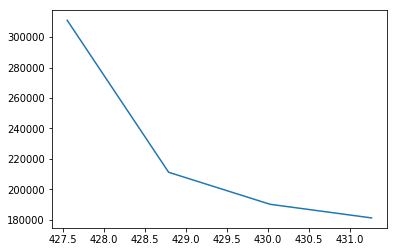

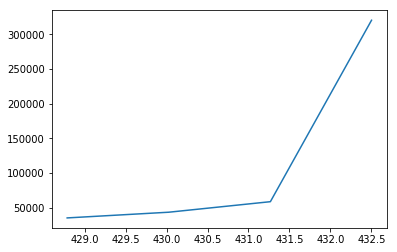

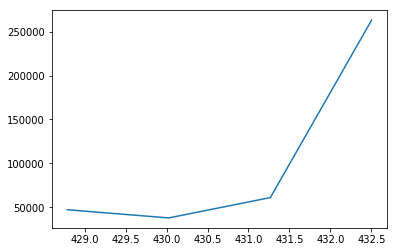

In [20]:
plot_chems(sorted_chems[0:10])

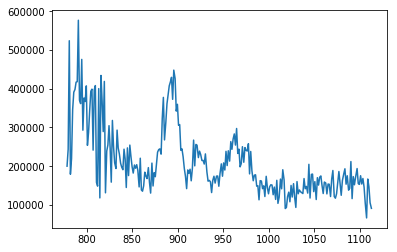

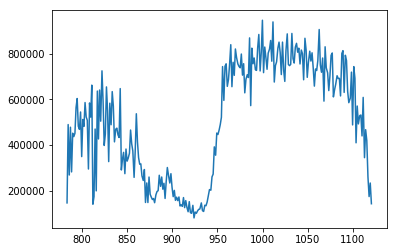

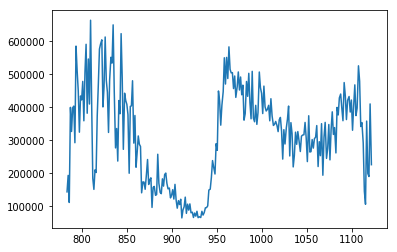

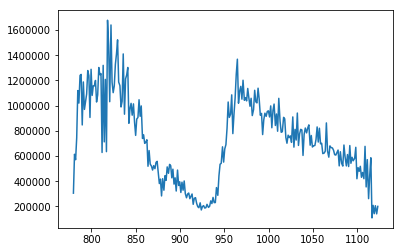

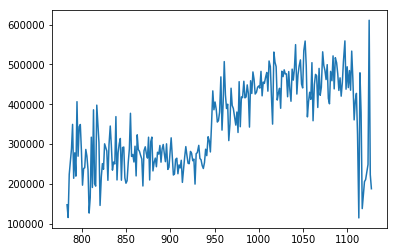

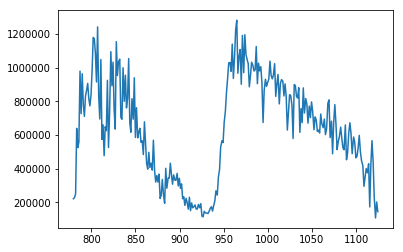

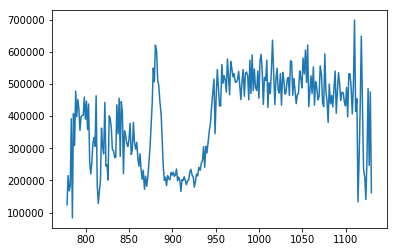

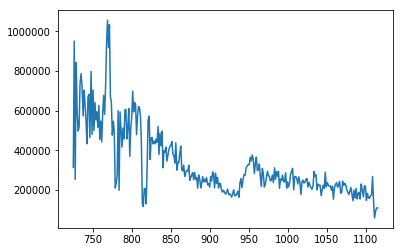

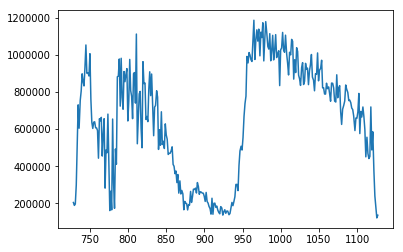

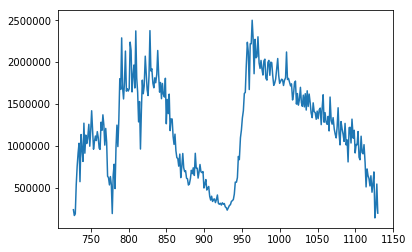

In [21]:
plot_chems(sorted_chems[-10:])

#### Add non-peaks regions of interest to the data

In [22]:
for chem in dataset:
    chem.type = 'data'
for noise in sorted_chems:
    noise.type = 'noise'

In [23]:
noisy_dataset = dataset + sorted_chems

In [24]:
# shuffle(noisy_dataset)

In [25]:
len(dataset)

9778

In [26]:
len(noisy_dataset)

11083

In [27]:
save_obj(dataset, '../models/dda_results/dataset.p')

In [28]:
save_obj(noisy_dataset, '../models/dda_results/noisy_dataset.p')

### Experiment by varying N and rt_tol

Don't print so much from the controller when running

In [29]:
set_log_level_warning()
# set_log_level_info()
# set_log_level_debug()

#### Set parameters

Varying parameters

In [30]:
Ns = list(range(2, 51, 2)) # top-N DDA fragmentation
rt_tols = list(range(5, 31, 5)) # the rt window around a selected precursor ion to prevent it from fragmented multiple times

In [31]:
print(Ns)
print(rt_tols)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
[5, 10, 15, 20, 25, 30]


Fixed parameters

In [32]:
isolation_window = 0.5   # the isolation window in Dalton around a selected precursor ion
ionisation_mode = POSITIVE
data = noisy_dataset
density = ps.density_estimator
min_ms1_intensity = 2.5E5 # minimum ms1 intensity to fragment

In [33]:
params = []
for N in Ns:
    for rt_tol in rt_tols:
        params.append({
            'N': N, 
            'rt_tol': rt_tol,
            'min_ms1_intensity': min_ms1_intensity,
            'isolation_window': isolation_window,
            'ionisation_mode': ionisation_mode,
            'data': data,
            'density': density,
            'min_rt': min_rt,
            'max_rt': max_rt
        })

In [34]:
len(params)

150

#### Run serially

In [35]:
def run_serial_experiment(param, i, total):
    analysis_name = 'experiment_N_%d_rttol_%d' % (param['N'], param['rt_tol'])    
    mzml_out = '../models/dda_results/%s.mzML' % analysis_name    
    pickle_out = '../models/dda_results/%s.p' % analysis_name

    if os.path.isfile(mzml_out) and os.path.isfile(pickle_out): 
        print('Skipping\t%d/%d\t%s' % (i, total, analysis_name))
    else:    
        print('Processing\t%d/%d\t%s' % (i, total, analysis_name))
        mass_spec = IndependentMassSpectrometer(param['ionisation_mode'], param['data'], density=param['density'])
        controller = TopNController(mass_spec, param['N'], param['isolation_window'], param['rt_tol'], 
                                    param['min_ms1_intensity'])
        controller.run(param['min_rt'], param['max_rt'], progress_bar=True)
        controller.write_mzML(analysis_name, mzml_out)    
        save_obj(controller, pickle_out)

In [36]:
for i in range(len(params)):
    param = params[i]
    run_serial_experiment(param, i+1, len(params))

Skipping	1/150	experiment_N_2_rttol_5
Skipping	2/150	experiment_N_2_rttol_10
Skipping	3/150	experiment_N_2_rttol_15
Skipping	4/150	experiment_N_2_rttol_20
Skipping	5/150	experiment_N_2_rttol_25
Skipping	6/150	experiment_N_2_rttol_30
Skipping	7/150	experiment_N_4_rttol_5
Skipping	8/150	experiment_N_4_rttol_10
Skipping	9/150	experiment_N_4_rttol_15
Skipping	10/150	experiment_N_4_rttol_20
Skipping	11/150	experiment_N_4_rttol_25
Skipping	12/150	experiment_N_4_rttol_30
Skipping	13/150	experiment_N_6_rttol_5
Skipping	14/150	experiment_N_6_rttol_10
Skipping	15/150	experiment_N_6_rttol_15
Skipping	16/150	experiment_N_6_rttol_20
Skipping	17/150	experiment_N_6_rttol_25
Skipping	18/150	experiment_N_6_rttol_30
Processing	19/150	experiment_N_8_rttol_5


1080.0538845192798it [04:30,  4.00it/s]                                                                                                                                 


Processing	20/150	experiment_N_8_rttol_10


1080.0457384718618it [04:09,  4.97it/s]                                                                                             


Processing	21/150	experiment_N_8_rttol_15


1080.055376704606it [04:07,  4.36it/s]                                                                                              


Processing	22/150	experiment_N_8_rttol_20


1080.231755093932it [04:05,  5.75it/s]                                                                                              


Processing	23/150	experiment_N_8_rttol_25


1080.0498890030883it [03:46,  4.77it/s]                                                                                             


Processing	24/150	experiment_N_8_rttol_30


1080.049568168964it [04:06,  4.38it/s]                                                                                              


Processing	25/150	experiment_N_10_rttol_5


1080.0318371971848it [04:05,  4.40it/s]                                                                                             


Processing	26/150	experiment_N_10_rttol_10


1080.048560936883it [04:18,  4.18it/s]                                                                                              


Processing	27/150	experiment_N_10_rttol_15


1080.1084987780464it [04:35,  4.62it/s]                                                                                             


Processing	28/150	experiment_N_10_rttol_20


1080.0023080724322it [04:08,  5.35it/s]                                                                                             


Processing	29/150	experiment_N_10_rttol_25


1080.1938116867627it [04:14,  4.24it/s]                                                                                             


Processing	30/150	experiment_N_10_rttol_30


1080.0920368673496it [04:10,  4.31it/s]                                                                                             


Processing	31/150	experiment_N_12_rttol_5


1080.03367115255it [03:42,  6.34it/s]                                                                                               


Processing	32/150	experiment_N_12_rttol_10


1080.0163203101083it [03:41,  5.40it/s]                                                                                             


Processing	33/150	experiment_N_12_rttol_15


1080.1065984940863it [03:58,  4.53it/s]                                                                                             


Processing	34/150	experiment_N_12_rttol_20


1080.0466325719426it [03:52,  4.64it/s]                                                                                             


Processing	35/150	experiment_N_12_rttol_25


1080.1009622396418it [04:07,  4.37it/s]                                                                                             


Processing	36/150	experiment_N_12_rttol_30


1080.0765210256743it [04:04,  4.42it/s]                                                                                             


Processing	37/150	experiment_N_14_rttol_5


1080.007908493696it [03:37,  4.98it/s]                                                                                              


Processing	38/150	experiment_N_14_rttol_10


1080.111097537288it [03:51,  6.49it/s]                                                                                              


Processing	39/150	experiment_N_14_rttol_15


1080.0672430329848it [03:50,  4.68it/s]                                                                                             


Processing	40/150	experiment_N_14_rttol_20


1080.0523492488853it [03:44,  4.80it/s]                                                                                             


Processing	41/150	experiment_N_14_rttol_25


1080.0213101962763it [03:44,  4.82it/s]                                                                                             


Processing	42/150	experiment_N_14_rttol_30


1080.0859798062847it [03:36,  5.20it/s]                                                                                             


Processing	43/150	experiment_N_16_rttol_5


1080.051211549445it [03:13,  5.59it/s]                                                                                              


Processing	44/150	experiment_N_16_rttol_10


1080.123496302499it [03:31,  5.10it/s]                                                                                              


Processing	45/150	experiment_N_16_rttol_15


1080.048399595831it [03:37,  4.96it/s]                                                                                              


Processing	46/150	experiment_N_16_rttol_20


1080.0473771940788it [03:39,  4.91it/s]                                                                                             


Processing	47/150	experiment_N_16_rttol_25


1080.0381439413231it [03:40,  4.89it/s]                                                                                             


Processing	48/150	experiment_N_16_rttol_30


1080.1544953757043it [03:41,  4.89it/s]                                                                                             


Processing	49/150	experiment_N_18_rttol_5


1080.0521124914899it [03:13,  5.58it/s]                                                                                             


Processing	50/150	experiment_N_18_rttol_10


1080.038967258551it [03:30,  5.13it/s]                                                                                              


Processing	51/150	experiment_N_18_rttol_15


1080.0809960311149it [03:33,  5.05it/s]                                                                                             


Processing	52/150	experiment_N_18_rttol_20


1080.0600796603997it [03:40,  4.91it/s]                                                                                             


Processing	53/150	experiment_N_18_rttol_25


1080.158736333926it [03:42,  4.85it/s]                                                                                              


Processing	54/150	experiment_N_18_rttol_30


1080.0471691063924it [03:42,  4.86it/s]                                                                                             


Processing	55/150	experiment_N_20_rttol_5


1080.0361364783996it [03:07,  5.77it/s]                                                                                             


Processing	56/150	experiment_N_20_rttol_10


1080.0622841780946it [03:25,  5.26it/s]                                                                                             


Processing	57/150	experiment_N_20_rttol_15


1080.0644901206442it [03:33,  5.05it/s]                                                                                             


Processing	58/150	experiment_N_20_rttol_20


1080.022642738886it [03:38,  4.94it/s]                                                                                              


Processing	59/150	experiment_N_20_rttol_25


1080.0680689420312it [03:40,  4.90it/s]                                                                                             


Processing	60/150	experiment_N_20_rttol_30


1080.0484925979333it [03:38,  6.76it/s]                                                                                             


Processing	61/150	experiment_N_22_rttol_5


1080.020151842973it [03:11,  6.64it/s]                                                                                              


Processing	62/150	experiment_N_22_rttol_10


1080.0517926265022it [03:25,  5.26it/s]                                                                                             


Processing	63/150	experiment_N_22_rttol_15


1080.3130945068824it [03:30,  5.13it/s]                                                                                             


Processing	64/150	experiment_N_22_rttol_20


1080.1415314847445it [03:34,  5.04it/s]                                                                                             


Processing	65/150	experiment_N_22_rttol_25


1080.0119424139027it [03:40,  4.90it/s]                                                                                             


Processing	66/150	experiment_N_22_rttol_30


1080.205862421687it [03:37,  4.98it/s]                                                                                              


Processing	67/150	experiment_N_24_rttol_5


1080.044187704806it [03:05,  5.81it/s]                                                                                              


Processing	68/150	experiment_N_24_rttol_10


1080.1186158254677it [03:23,  5.31it/s]                                                                                             


Processing	69/150	experiment_N_24_rttol_15


1080.1352262897872it [03:31,  5.10it/s]                                                                                             


Processing	70/150	experiment_N_24_rttol_20


1080.0516640989965it [03:37,  7.17it/s]                                                                                             


Processing	71/150	experiment_N_24_rttol_25


1080.062517587256it [03:40,  4.90it/s]                                                                                              


Processing	72/150	experiment_N_24_rttol_30


1080.0266469088322it [03:44,  4.82it/s]                                                                                             


Processing	73/150	experiment_N_26_rttol_5


1080.103496072988it [03:11,  5.64it/s]                                                                                              


Processing	74/150	experiment_N_26_rttol_10


1080.0034532228185it [03:23,  5.82it/s]                                                                                             


Processing	75/150	experiment_N_26_rttol_15


1080.2469504099724it [03:23,  5.30it/s]                                                                                             


Processing	76/150	experiment_N_26_rttol_20


1080.1383680339914it [03:33,  6.78it/s]                                                                                             


Processing	77/150	experiment_N_26_rttol_25


1080.055959314257it [03:32,  5.08it/s]                                                                                              


Processing	78/150	experiment_N_26_rttol_30


1080.0441283271882it [03:41,  4.87it/s]                                                                                             


Processing	79/150	experiment_N_28_rttol_5


1080.092289733798it [03:05,  5.84it/s]                                                                                              


Processing	80/150	experiment_N_28_rttol_10


1080.3226538498864it [03:24,  5.29it/s]                                                                                             


Processing	81/150	experiment_N_28_rttol_15


1080.1561464466722it [03:27,  5.20it/s]                                                                                             


Processing	82/150	experiment_N_28_rttol_20


1080.0190158005537it [03:41,  4.88it/s]                                                                                             


Processing	83/150	experiment_N_28_rttol_25


1080.2115623452862it [03:40,  4.89it/s]                                                                                             


Processing	84/150	experiment_N_28_rttol_30


1080.0235436179494it [03:42,  4.86it/s]                                                                                             


Processing	85/150	experiment_N_30_rttol_5


1080.0728714798022it [03:08,  5.73it/s]                                                                                             


Processing	86/150	experiment_N_30_rttol_10


1080.0717000042298it [03:26,  5.22it/s]                                                                                             


Processing	87/150	experiment_N_30_rttol_15


1080.2412224453183it [03:36,  4.98it/s]                                                                                             


Processing	88/150	experiment_N_30_rttol_20


1080.0264833932422it [03:39,  4.92it/s]                                                                                             


Processing	89/150	experiment_N_30_rttol_25


1080.1922778210574it [03:41,  4.88it/s]                                                                                             


Processing	90/150	experiment_N_30_rttol_30


1080.1823264826726it [03:38,  7.99it/s]                                                                                             


Processing	91/150	experiment_N_32_rttol_5


1080.009331926702it [03:04,  5.84it/s]                                                                                              


Processing	92/150	experiment_N_32_rttol_10


1080.0574750123778it [03:30,  6.35it/s]                                                                                             


Processing	93/150	experiment_N_32_rttol_15


1080.0525403146546it [03:33,  5.06it/s]                                                                                             


Processing	94/150	experiment_N_32_rttol_20


1080.1497471386924it [03:39,  4.93it/s]                                                                                             


Processing	95/150	experiment_N_32_rttol_25


1080.1785495452277it [03:40,  6.68it/s]                                                                                             


Processing	96/150	experiment_N_32_rttol_30


1080.2059976501193it [03:43,  4.83it/s]                                                                                             


Processing	97/150	experiment_N_34_rttol_5


1080.12172712679it [03:08,  5.73it/s]                                                                                               


Processing	98/150	experiment_N_34_rttol_10


1080.0177451379075it [03:29,  5.16it/s]                                                                                             


Processing	99/150	experiment_N_34_rttol_15


1080.0483331020478it [03:35,  5.02it/s]                                                                                             


Processing	100/150	experiment_N_34_rttol_20


1080.2057452718889it [03:38,  4.93it/s]                                                                                             


Processing	101/150	experiment_N_34_rttol_25


1080.0598510350287it [03:39,  4.92it/s]                                                                                             


Processing	102/150	experiment_N_34_rttol_30


1080.040842523406it [03:44,  4.81it/s]                                                                                              


Processing	103/150	experiment_N_36_rttol_5


1080.2822201084493it [03:09,  5.69it/s]                                                                                             


Processing	104/150	experiment_N_36_rttol_10


1080.0617917403106it [03:26,  5.23it/s]                                                                                             


Processing	105/150	experiment_N_36_rttol_15


1080.1411612938145it [03:29,  5.17it/s]                                                                                             


Processing	106/150	experiment_N_36_rttol_20


1080.0333058250374it [03:29,  5.16it/s]                                                                                             


Processing	107/150	experiment_N_36_rttol_25


1080.076894492531it [03:31,  5.11it/s]                                                                                              


Processing	108/150	experiment_N_36_rttol_30


1080.015930827313it [03:34,  8.00it/s]                                                                                              


Processing	109/150	experiment_N_38_rttol_5


1080.1248137152452it [03:00,  6.00it/s]                                                                                             


Processing	110/150	experiment_N_38_rttol_10


1080.212776836444it [03:16,  6.52it/s]                                                                                              


Processing	111/150	experiment_N_38_rttol_15


1080.1509635150803it [03:24,  5.29it/s]                                                                                             


Processing	112/150	experiment_N_38_rttol_20


1080.0502702327071it [03:34,  5.04it/s]                                                                                             


Processing	113/150	experiment_N_38_rttol_25


1080.058909028256it [03:35,  5.02it/s]                                                                                              


Processing	114/150	experiment_N_38_rttol_30


1080.1265549656564it [03:34,  5.03it/s]                                                                                             


Processing	115/150	experiment_N_40_rttol_5


1080.1058834450203it [03:02,  5.50it/s]                                                                                             


Processing	116/150	experiment_N_40_rttol_10


1080.1259031420898it [03:16,  5.48it/s]                                                                                             


Processing	117/150	experiment_N_40_rttol_15


1080.091773794255it [03:26,  5.23it/s]                                                                                              


Processing	118/150	experiment_N_40_rttol_20


1080.056931968806it [03:32,  5.08it/s]                                                                                              


Processing	119/150	experiment_N_40_rttol_25


1080.1562098351299it [03:34,  5.04it/s]                                                                                             


Processing	120/150	experiment_N_40_rttol_30


1080.0715900623081it [03:51,  4.67it/s]                                                                                             


Processing	121/150	experiment_N_42_rttol_5


1080.1411898297338it [03:11,  5.65it/s]                                                                                             


Processing	122/150	experiment_N_42_rttol_10


1080.06380496465it [03:29,  5.15it/s]                                                                                               


Processing	123/150	experiment_N_42_rttol_15


1080.076645318753it [03:27,  6.22it/s]                                                                                              


Processing	124/150	experiment_N_42_rttol_20


1080.048230477615it [03:29,  5.15it/s]                                                                                              


Processing	125/150	experiment_N_42_rttol_25


1080.1192217153384it [03:30,  5.13it/s]                                                                                             


Processing	126/150	experiment_N_42_rttol_30


1080.024274083844it [03:31,  6.30it/s]                                                                                              


Processing	127/150	experiment_N_44_rttol_5


1080.1436680612994it [02:53,  6.22it/s]                                                                                             


Processing	128/150	experiment_N_44_rttol_10


1080.0311636132683it [03:16,  5.49it/s]                                                                                             


Processing	129/150	experiment_N_44_rttol_15


1080.0392202252513it [03:26,  5.22it/s]                                                                                             


Processing	130/150	experiment_N_44_rttol_20


1080.0413133150726it [03:31,  5.96it/s]                                                                                             


Processing	131/150	experiment_N_44_rttol_25


1080.025053662179it [03:32,  5.07it/s]                                                                                              


Processing	132/150	experiment_N_44_rttol_30


1080.0639055970282it [03:31,  5.11it/s]                                                                                             


Processing	133/150	experiment_N_46_rttol_5


1080.0253067549722it [02:59,  6.02it/s]                                                                                             


Processing	134/150	experiment_N_46_rttol_10


1080.0797006110995it [03:18,  5.45it/s]                                                                                             


Processing	135/150	experiment_N_46_rttol_15


1080.1205030842673it [03:26,  5.24it/s]                                                                                             


Processing	136/150	experiment_N_46_rttol_20


1080.0100364617554it [03:38,  6.50it/s]                                                                                             


Processing	137/150	experiment_N_46_rttol_25


1080.0525438777265it [03:50,  4.69it/s]                                                                                             


Processing	138/150	experiment_N_46_rttol_30


1080.0150559714734it [03:51,  5.76it/s]                                                                                             


Processing	139/150	experiment_N_48_rttol_5


1080.1863672603333it [03:18,  5.44it/s]                                                                                             


Processing	140/150	experiment_N_48_rttol_10


1080.0009751510124it [03:37,  4.98it/s]                                                                                             


Processing	141/150	experiment_N_48_rttol_15


1080.0922704657867it [03:46,  4.76it/s]                                                                                             


Processing	142/150	experiment_N_48_rttol_20


1080.226321151251it [04:01,  4.47it/s]                                                                                              


Processing	143/150	experiment_N_48_rttol_25


1080.1274741979908it [03:55,  4.58it/s]                                                                                             


Processing	144/150	experiment_N_48_rttol_30


1080.1746572984937it [04:00,  4.48it/s]                                                                                             


Processing	145/150	experiment_N_50_rttol_5


1080.018992593167it [03:24,  5.29it/s]                                                                                              


Processing	146/150	experiment_N_50_rttol_10


1080.1616558755827it [03:44,  4.82it/s]                                                                                             


Processing	147/150	experiment_N_50_rttol_15


1080.1460844059243it [04:11,  4.30it/s]                                                                                             


Processing	148/150	experiment_N_50_rttol_20


1080.0235607031173it [04:57,  3.63it/s]                                                                                                                                 


Processing	149/150	experiment_N_50_rttol_25


1080.0683863272711it [05:10,  3.48it/s]                                                                                                                                 


Processing	150/150	experiment_N_50_rttol_30


1080.0947541068274it [05:01,  4.57it/s]                                                                                                                                 


#### Run in parallel

Doesn't quite work yet ...

In [37]:
# import ipyparallel as ipp

In [38]:
# def run_parallel_experiment(param):
#     import sys
#     sys.path.append('C:\\Users\\joewa\\Work\\git\\clms\\Simulator\\codes')
#     from VMSfunctions.MassSpec import IndependentMassSpectrometer
#     from VMSfunctions.Controller import TopNController
    
#     mass_spec = IndependentMassSpectrometer(param['ionisation_mode'], param['data'], density=param['density'])
#     controller = TopNController(mass_spec, param['N'], param['isolation_window'], param['rt_tol'])
#     controller.run(param['min_rt'], param['max_rt'], progress_bar=False)
#     return controller

In [39]:
# rc = ipp.Client()
# dview = rc[:] # use all engines

In [40]:
# controllers = dview.map(run_parallel_experiment, params)
# for controller in controllers:
#     print(controller.N, controller.rt_tol)